In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-06-17 17:14:01.059061: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-17 17:14:01.556048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-17 17:14:01.556171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-17 17:14:01.639954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 17:14:01.811039: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=224
BATCH_SIZE=32
DATA_PATH="../../data/processed/04_kaggle_dataset"

datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 8032 images belonging to 2 classes.
Found 2007 images belonging to 2 classes.


In [3]:
print("클래스 인덱스:", train_generator.class_indices)

클래스 인덱스: {'Closed': 0, 'Opened': 1}


# MobileNetV2

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.3)(x)
output=Dense(1, activation="sigmoid")(x)

model=Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

#model.summary()

In [8]:
checkpoint_path="../../src/models/19_mobilenet/best_model.keras"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
esc=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
mcp=ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)

In [9]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, callbacks=[esc, mcp], verbose=1)

Epoch 1/20


2025-06-17 17:25:10.525468: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-17 17:25:10.868582: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-17 17:25:10.868626: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-17 17:25:10.868703: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-17 17:25:11.801083: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-17 17:25:11.801240: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

  3/251 [..............................] - ETA: 6s - loss: 0.9529 - accuracy: 0.3958   

2025-06-17 17:25:12.322871: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-17 17:25:12.388419: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:408] Couldn't read CUDA driver version.
I0000 00:00:1750148712.400445   25356 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.6299
Epoch 1: val_loss improved from inf to 0.43785, saving model to ../../src/models/19_mobilenet/best_model.keras
251/251 [==============================] - 56s 211ms/step - loss: 0.6465 - accuracy: 0.6299 - val_loss: 0.4379 - val_accuracy: 0.8585
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8445
Epoch 2: val_loss improved from 0.43785 to 0.31274, saving model to ../../src/models/19_mobilenet/best_model.keras
251/251 [==============================] - 50s 199ms/step - loss: 0.3989 - accuracy: 0.8445 - val_loss: 0.3127 - val_accuracy: 0.9048
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.3184 - accuracy: 0.8820
Epoch 3: val_loss improved from 0.31274 to 0.27338, saving model to ../../src/models/19_mobilenet/best_model.keras
251/251 [==============================] - 49s 197ms/step - loss: 0.3184 - accuracy: 0.8820 - val_loss: 0.2734 - v

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

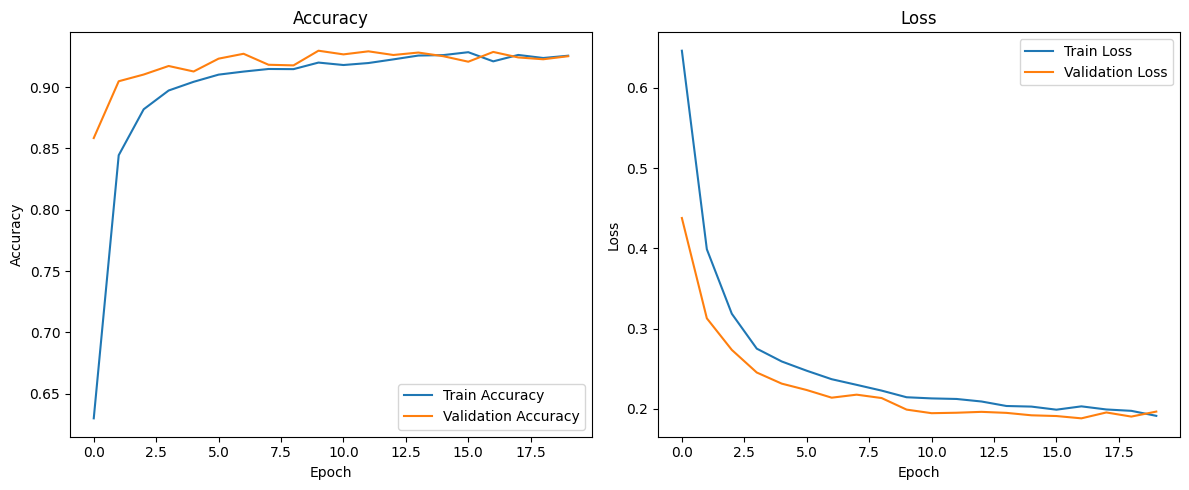

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/19_mobilenet_training_plot.png")
plt.show()

In [14]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["Closed", "Opened"])
print("=== Classification Report ===")
print(report)

os.makedirs("../../results/reports", exist_ok=True)
with open("../../results/reports/19_mobilenet_classification_report.txt", "w") as f:
    f.write(report)

=== Classification Report ===
              precision    recall  f1-score   support

      Closed       0.94      0.91      0.93      1000
      Opened       0.92      0.94      0.93      1007

    accuracy                           0.93      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.93      0.93      0.93      2007



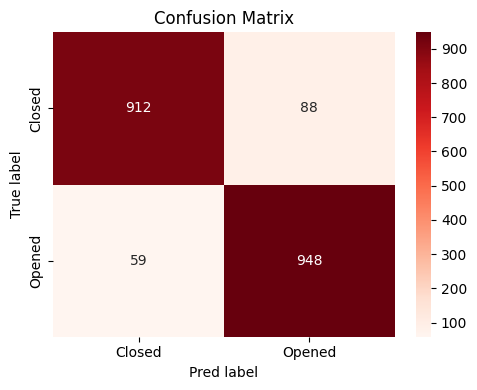

In [15]:
conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Closed", "Opened"], yticklabels=["Closed", "Opened"])
plt.title("Confusion Matrix")
plt.xlabel("Pred label")
plt.ylabel("True label")
plt.tight_layout()

# 이미지 저장
os.makedirs("../../results/images", exist_ok=True)
plt.savefig("../../results/images/19_mobilenet_confusion_matrix.png")
plt.show()